# "기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 생성하기"
> "Pytorch Tutorial 따라서 코드 돌려보며, 내용 확인"

- toc:true
- branch: master
- badges: true
- comments: true
- author: In Chan
- categories: [jupyter, deep learning]

# 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 생성하기
___

## 1. 데이터준비
- txt 파일을 찾아서, 어레이로 분리하고, ASCII로 변환하고, 딕셔너리 자료형 생성

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # EOS(end of sentence) 기호 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


## 2. 네트워크 생성

- 더 나은 성능을 위해 선형 레이어(o2o layer) 추가, Drop out 추가


![image](https://i.imgur.com/jzVrf7f.png)

In [3]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## 3. 학습

In [4]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
# 실행 예시  = ('German', 'Brauer')
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

- 각 스텝마다(즉, 학습 단어의 각 문자 마다) 네트워크의 입력 = (언어, 현재 문자, 히든스테이트) , 출력 = (다음 문자, 다음 히든스테이트)
- 따라서, 각 학습 세트마다 언어, 입력 문자의 세트, 출력/목표 문자의 세트가 필요

- 각 시간 단계마다 현재 문자에서 다음 문자를 예측하기 때문에, 문자 쌍은 한 줄(하나의 이름)에서 연속된 문자 그룹


- 예를 들어 "ABCD<EOS>" 는 (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”) 로 생성


![image](https://i.imgur.com/JH58tXY.png)

In [5]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
# Data
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 두번째 문자 부터 마지막(EOS) 까지의 LongTensor
# Label
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

- 학습에서 편의를 위해 무작위로 데이터를 가져오고, input과 output의 형태로 바꾸어주는 함수

In [6]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## 4. 네트워크 학습

- 마지막 출력만 사용하는 분류와는 달리, 모든 타임 스텝에서 예측을 진행하므로, 각 단계에서의 손실을 계산해줘야함

In [7]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden() # initialization

    rnn.zero_grad() 

    loss = 0

    for i in range(input_line_tensor.size(0)):
        # 하나의 문자씩 들어감
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden) 
        # 각 타임 스텝에 대한 Loss 계산
        l = criterion(output, target_line_tensor[i]) 
        loss += l

    loss.backward() # Loss 역전파

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [8]:
import time
import math

# 학습에 걸리는 시간을 추적하기 위한 것
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [9]:
# RNN(글자 Class , Hidden Size, output_size)
rnn = RNN(n_letters, 128, n_letters) 

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # plot_every 마다 초기화

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 22s (5000 5%) 2.3946
0m 44s (10000 10%) 3.4316
1m 7s (15000 15%) 2.4484
1m 29s (20000 20%) 3.3045
1m 51s (25000 25%) 2.7333
2m 13s (30000 30%) 2.7747
2m 35s (35000 35%) 2.9738
2m 57s (40000 40%) 2.6746
3m 19s (45000 45%) 2.2482
3m 40s (50000 50%) 2.3516
4m 1s (55000 55%) 2.0257
4m 22s (60000 60%) 2.5526
4m 43s (65000 65%) 2.1610
5m 4s (70000 70%) 2.7014
5m 25s (75000 75%) 1.2569
5m 46s (80000 80%) 2.7089
6m 7s (85000 85%) 4.1362
6m 28s (90000 90%) 2.6643
6m 49s (95000 95%) 3.3536
7m 10s (100000 100%) 2.3982


## 4. 결과 도식화

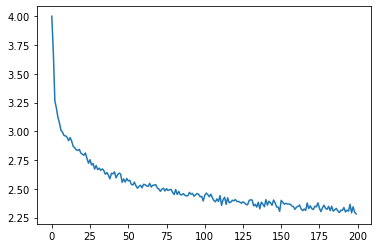

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## 5. 네트워크 샘플링
- 입력 : (카테고리, 시작문자, 히든 스테이트)
- 시작 문자로 output_name 문자열 생성
- 최대 출력 길이까지
    - 시작 문자를 네트워크에 전달
    - 다음 문자와 다음 히든 스테이트를 얻음
    - EOS면 Stop, 그 외의 문자라면 output_name에 추가하고 계속

In [14]:
max_length = 20

# 카테고리와 시작 문자로 부터 샘플링 하기
def sample(category, start_letter='A'):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        # inputTensor : 입력을 위해 문자를 One-Hot 백터로 인코딩하는 함수
        input = inputTensor(start_letter) 
        # 맨 처음 Time Step에 들어가기 전에만 parameter 초기화를 해줌
        hidden = rnn.initHidden() 

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            # 텐서의 가장 큰 값 및 주소 , 즉 topv은 max값, topi는 argmax 값
            topv, topi = output.topk(1) 
            # 모델에서 예측한 문자의 index
            topi = topi[0][0] 
            if topi == n_letters - 1: ## EOS면 종료
                break
            else:
                letter = all_letters[topi] # output name에 문자 추가
                output_name += letter
            input = inputTensor(letter) # 다음 time step의 인풋으로 넣어줌 

        return output_name

# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rover
Uantovak
Shantov
Gerren
Eren
Romer
Santaraz
Pore
Allan
Chan
Han
Iha


In [20]:
samples('Korean', 'OEN')

Ohon
Eon
Non
